In [10]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models


In [11]:
import os
import tensorflow as tf

# Base folder containing species subfolders:
ROOT_DIR = "sonogram_data_forward"

# Discover species (top-level dirs under ROOT_DIR)
species = sorted([
    d for d in tf.io.gfile.listdir(ROOT_DIR)
    if tf.io.gfile.isdir(os.path.join(ROOT_DIR, d))
])

# For each species, collect its .png paths under its 'png/' subfolder
all_paths = {}
for sp in species:
    png_dir = os.path.join(ROOT_DIR, sp, "png")
    pattern = os.path.join(png_dir, "*.png")
    all_paths[sp] = sorted(tf.io.gfile.glob(pattern))

# Example: print how many images for each species
for sp, paths in all_paths.items():
    print(f"{sp}: {len(paths)} images")


Culex: 117 images
aedes aegypti: 10 images


In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

# all_paths is a dict mapping species -> list of PNG file paths
# e.g. all_paths = {'Culex': [...], 'aedes aegypti': [...]}

# 1) Split each species’ list into train/test
train_paths = {}
test_paths  = {}
for species, paths in all_paths.items():
    train, test = train_test_split(
        paths,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )
    train_paths[species] = train
    test_paths[species]  = test

# 2) (Optional) copy into separate directories for each species & split
for split_name, split_dict in (('train', train_paths), ('test', test_paths)):
    for species, paths in split_dict.items():
        out_dir = os.path.join(split_name, species)
        os.makedirs(out_dir, exist_ok=True)
        for src in paths:
            dst = os.path.join(out_dir, os.path.basename(src))
            shutil.copy2(src, dst)

# Now you have:
# train/Culex/*.png
# test/Culex/*.png
# train/aedes aegypti/*.png
# test/aedes aegypti/*.png
#
# You can point your two separate models at train/Culex vs. train/aedes aegypti (and their tests).


In [13]:
from PIL import Image
import os

# Folders to process
ROOT_DIRS = ['train', 'test']
IMG_SIZE  = (128, 128)

for root in ROOT_DIRS:
    if not os.path.isdir(root):
        print(f"Warning: '{root}' not found, skipping.")
        continue

    for species in os.listdir(root):
        species_dir = os.path.join(root, species)
        if not os.path.isdir(species_dir):
            continue

        for fname in os.listdir(species_dir):
            if not fname.lower().endswith('.png'):
                continue
            img_path = os.path.join(species_dir, fname)

            # Open, resize, overwrite (preserving original color mode)
            with Image.open(img_path) as img:
                img_resized = img.resize(IMG_SIZE, Image.ANTIALIAS)
                img_resized.save(img_path)

            print(f"Resized {img_path} → {IMG_SIZE}")


C:\Users\alber\AppData\Local\Temp\ipykernel_25252\1363085912.py:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(IMG_SIZE, Image.ANTIALIAS)


Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_11_forward.png → (128, 128)
Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_1_forward.png → (128, 128)
Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_21_forward.png → (128, 128)
Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_26_forward.png → (128, 128)
Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_31_forward.png → (128, 128)
Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_36_forward.png → (128, 128)
Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_41_forward.png → (128, 128)
Resized train\aedes aegypti\030724_Liverpool_male_mos1_253deg_LSwAv_6_forward.png → (128, 128)
Resized train\Culex\2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_103_forward.png → (128, 128)
Resized train\Culex\2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection_5 min_270-27_LSwAv_108_forward.png → (128, 128)
Re

In [14]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models

# ─── User params ───────────────────────────────────────────
IMG_HEIGHT   = 128
IMG_WIDTH    = 128
IMG_CHANNELS = 3       # change to 1 if using grayscale
BATCH_SIZE   = 32
EPOCHS       = 1000

TRAIN_ROOT = "train"
TEST_ROOT  = "test"
MODELS_DIR = "models"

# ─── Data loader ───────────────────────────────────────────
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img

def make_dataset_for_species(root_dir, species, shuffle):
    pattern = os.path.join(root_dir, species, "*.png")
    ds = tf.data.Dataset.list_files(pattern, shuffle=shuffle)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# ─── Model builder ─────────────────────────────────────────
def build_autoencoder(input_shape):
    inp = layers.Input(shape=input_shape)
    x   = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x   = layers.MaxPool2D((2,2), padding='same')(x)
    x   = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x   = layers.MaxPool2D((2,2), padding='same')(x)
    latent = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2,2))(latent)
    x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    out = layers.Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same')(x)

    ae = models.Model(inp, out)
    ae.compile(optimizer='adam', loss='mse')
    return ae

# ─── Train loop ────────────────────────────────────────────
from tensorflow.keras.callbacks import EarlyStopping

# … your imports, params, data loader, build_autoencoder, EarlyStopping setup …

species_list = [
    d for d in os.listdir(TRAIN_ROOT)
    if os.path.isdir(os.path.join(TRAIN_ROOT, d))
]

for species in species_list:
    print(f"\n=== Training autoencoder for species: {species} ===")

    # prepare datasets
    train_ds = make_dataset_for_species(TRAIN_ROOT, species, shuffle=True)
    test_ds  = make_dataset_for_species(TEST_ROOT,  species, shuffle=False)

    # build model
    autoencoder = build_autoencoder((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # EarlyStopping callback
    es = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )

    # train with callbacks
    history = autoencoder.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=test_ds,
        callbacks=[es]
    )

    # save model
    out_dir = os.path.join(MODELS_DIR, species)
    os.makedirs(out_dir, exist_ok=True)
    autoencoder.save(os.path.join(out_dir, "autoencoder.h5"))
    print(f"[+] Saved model for {species}")



=== Training autoencoder for species: aedes aegypti ===
Epoch 1/1000
1/1 [==============================] - 1s 505ms/step - loss: 0.1938 - val_loss: 0.1751
Epoch 2/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.1791 - val_loss: 0.1553
Epoch 3/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.1614 - val_loss: 0.1264
Epoch 4/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.1356 - val_loss: 0.0961
Epoch 5/1000
1/1 [==============================] - 0s 122ms/step - loss: 0.1081 - val_loss: 0.0796
Epoch 6/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.0922 - val_loss: 0.0614
Epoch 7/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.0717 - val_loss: 0.0442
Epoch 8/1000
1/1 [==============================] - 0s 160ms/step - loss: 0.0487 - val_loss: 0.0692
Epoch 9/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.0644 - val_loss: 0.0669
Epoch 10/1000
1/1 [=============================

== Plotting for species: Culex ==
1/1 [==============================] - 0s 131ms/step


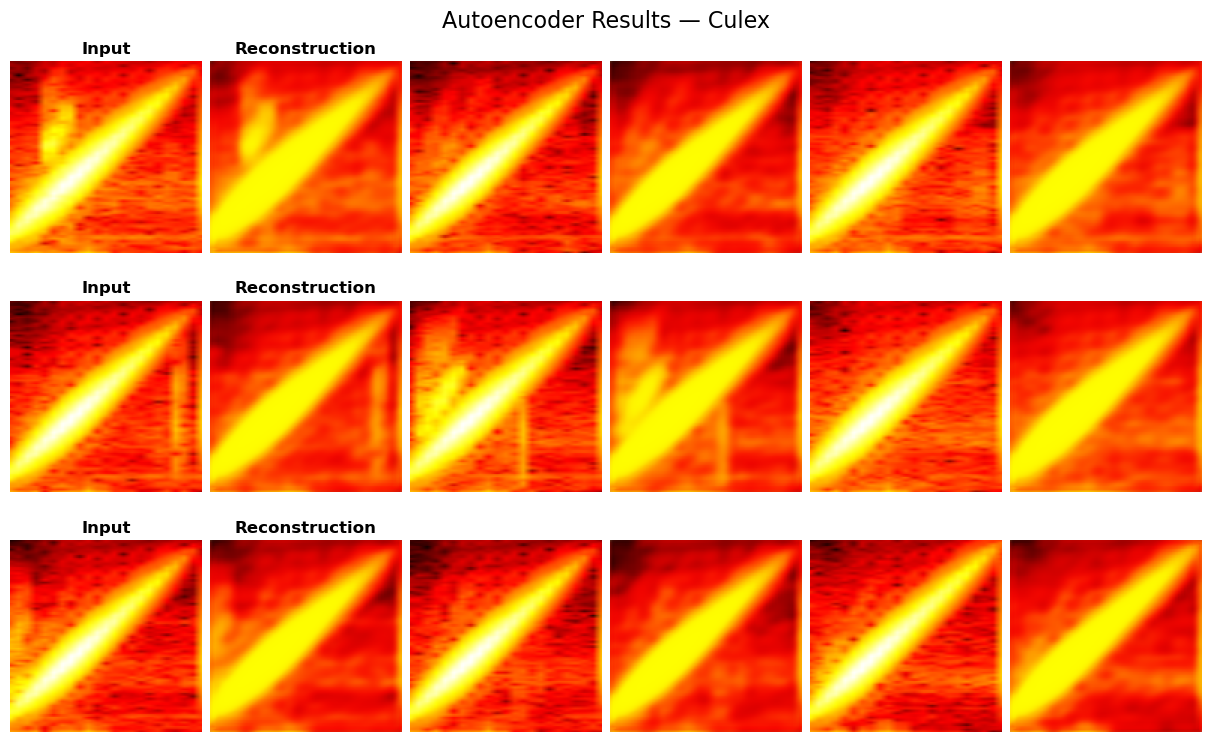

== Plotting for species: aedes aegypti ==
1/1 [==============================] - 0s 77ms/step


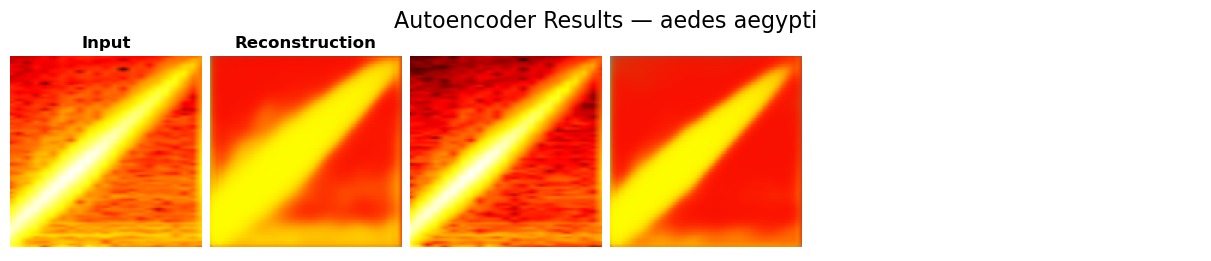

In [15]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# ─── Settings ─────────────────────────────────────────────
IMG_HEIGHT   = 128
IMG_WIDTH    = 128
IMG_CHANNELS = 3      # set to 1 if your sonograms are grayscale
BATCH_SIZE   = 32

TRAIN_ROOT   = "train"
TEST_ROOT    = "test"
MODELS_DIR   = "models"

# ─── Data pipeline ───────────────────────────────────────
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)  # normalize to [0,1]
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img  # (input, target)

def make_dataset_for_species(root_dir, species, shuffle=False):
    pattern = os.path.join(root_dir, species, "*.png")
    ds = tf.data.Dataset.list_files(pattern, shuffle=shuffle)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# ─── Visualization loop ──────────────────────────────────
# Find all species by listing subfolders in TEST_ROOT
species_list = sorted([
    d for d in os.listdir(TEST_ROOT)
    if os.path.isdir(os.path.join(TEST_ROOT, d))
])

for species in species_list:
    print(f"== Plotting for species: {species} ==")
    # 1) Load model
    model_path = os.path.join(MODELS_DIR, species, "autoencoder.h5")
    autoencoder = tf.keras.models.load_model(model_path)

    # 2) Prepare test dataset (no shuffling)
    test_ds = make_dataset_for_species(TEST_ROOT, species, shuffle=False)

    # 3) Grab one batch
    for x_batch, _ in test_ds.take(1):
        reconstructions = autoencoder.predict(x_batch)
        break

    # 4) Decide how many to show
    n = min(9, x_batch.shape[0])
    rows = (n // 3) + (1 if n % 3 else 0)
    cols = 6  # each row: [in, recon] × 3

    # 5) Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2.5), constrained_layout=True)
    axes = axes.flatten()

    # 6) Plot
    for i in range(n):
        # input
        axes[i*2].imshow(x_batch[i].numpy())
        axes[i*2].axis("off")
        if i % 3 == 0:
            axes[i*2].set_title("Input", fontweight="bold")
        # reconstruction
        axes[i*2+1].imshow(reconstructions[i])
        axes[i*2+1].axis("off")
        if i % 3 == 0:
            axes[i*2+1].set_title("Reconstruction", fontweight="bold")

    # 7) Turn off extras
    for j in range(n*2, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Autoencoder Results — {species}", fontsize=16)
    plt.show()


Processing species: Culex
1/1 [==============================] - 0s 119ms/step
Processing species: aedes aegypti
1/1 [==============================] - 0s 67ms/step


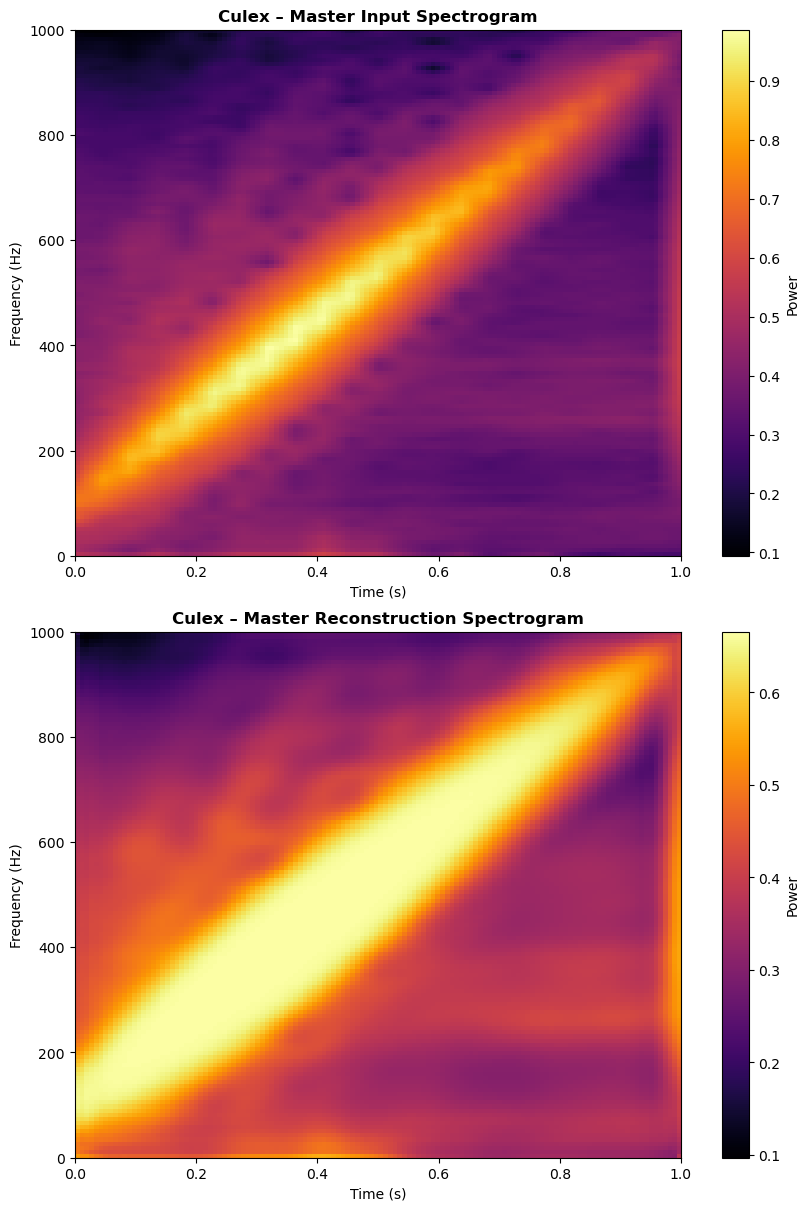

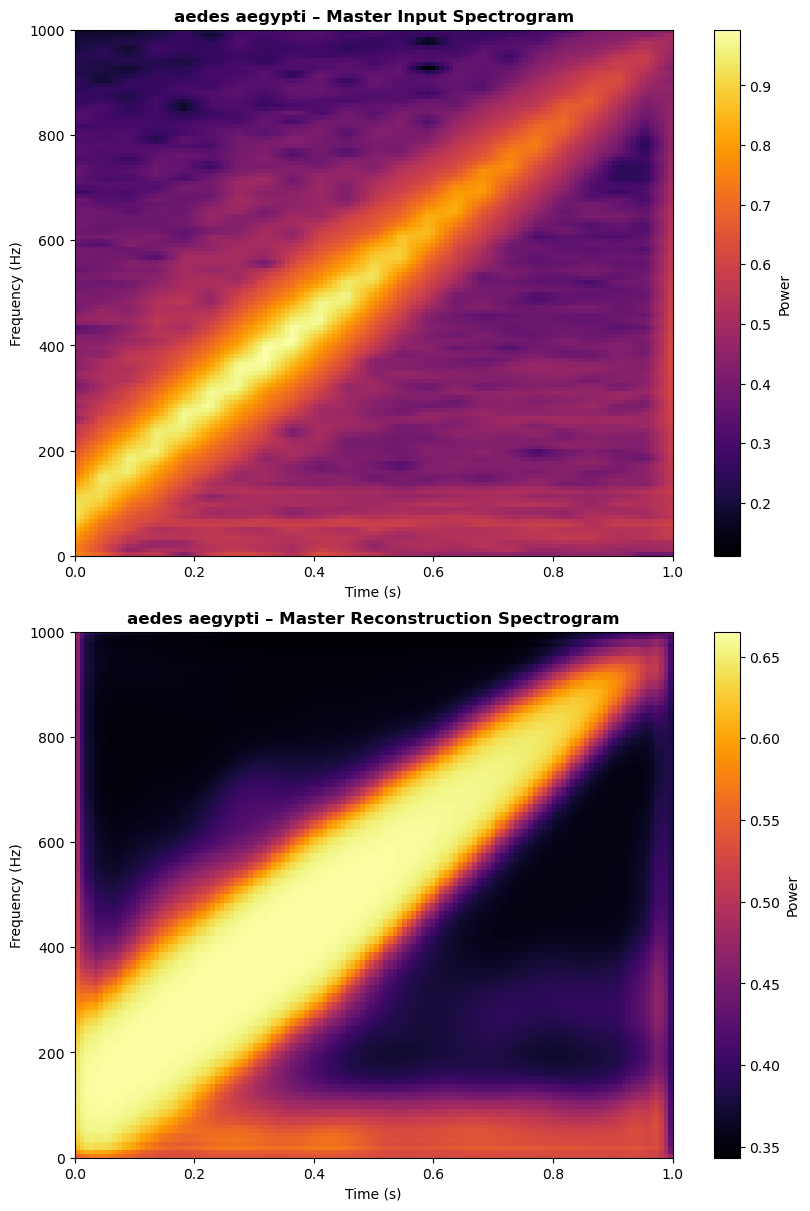

In [16]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ─── Settings ─────────────────────────────────────────────
IMG_HEIGHT   = 128
IMG_WIDTH    = 128
IMG_CHANNELS = 3     # or 1 if grayscale
BATCH_SIZE   = 32

TEST_ROOT    = "test"
MODELS_DIR   = "models"

# ─── Data pipeline ───────────────────────────────────────
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img

def make_dataset_for_species(root_dir, species):
    pattern = os.path.join(root_dir, species, "*.png")
    ds = tf.data.Dataset.list_files(pattern, shuffle=False)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# ─── Compute & plot master spectrograms per species ────────
extent = [0, 1, 0, 1000]  # time 0–1s, freq 0–1000Hz

species_list = sorted([
    d for d in os.listdir(TEST_ROOT)
    if os.path.isdir(os.path.join(TEST_ROOT, d))
])

for species in species_list:
    print(f"Processing species: {species}")

    # Load model
    model_path = os.path.join(MODELS_DIR, species, "autoencoder.h5")
    autoencoder = tf.keras.models.load_model(model_path)

    # Build dataset
    test_ds = make_dataset_for_species(TEST_ROOT, species)

    # Collect all inputs and reconstructions
    all_inputs = []
    all_reconstructions = []
    for x_batch, _ in test_ds:
        recon = autoencoder.predict(x_batch)
        all_inputs.append(x_batch.numpy())
        all_reconstructions.append(recon)
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_reconstructions = np.concatenate(all_reconstructions, axis=0)

    # Compute master spectrograms (mean across examples)
    # If RGB, take mean across channel axis or display one channel
    if IMG_CHANNELS == 1:
        master_input = np.mean(all_inputs, axis=0)[:, :, 0]
        master_recon = np.mean(all_reconstructions, axis=0)[:, :, 0]
    else:
        # average across examples first, then optionally convert to grayscale via mean across channels
        avg_input = np.mean(all_inputs, axis=0)
        avg_recon = np.mean(all_reconstructions, axis=0)
        master_input = np.mean(avg_input, axis=-1)  # collapse RGB → gray
        master_recon = np.mean(avg_recon, axis=-1)

    # Plot for this species
    fig, axes = plt.subplots(2, 1, figsize=(8, 12), constrained_layout=True)

    im0 = axes[0].imshow(master_input, origin='upper', aspect='auto', extent=extent, cmap='inferno')
    axes[0].set_title(f"{species} – Master Input Spectrogram", fontweight='bold')
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Frequency (Hz)")
    fig.colorbar(im0, ax=axes[0], label='Power')

    im1 = axes[1].imshow(master_recon, origin='upper', aspect='auto', extent=extent, cmap='inferno')
    axes[1].set_title(f"{species} – Master Reconstruction Spectrogram", fontweight='bold')
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Frequency (Hz)")
    fig.colorbar(im1, ax=axes[1], label='Power')


In [17]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# ─── Params ─────────────────────────────────────────────────
DATA_ROOT        = "sonogram_data_forward"
IMG_HEIGHT       = 128
IMG_WIDTH        = 128
IMG_CHANNELS     = 3    # change to 1 if grayscale
BATCH_SIZE       = 16
N_SAMPLES_PER_SP = 50
TEST_SIZE        = 0.2
RANDOM_SEED      = 42
EPOCHS           = 1000
MODELS_DIR       = "models"

# ─── Gather 50 samples per species ──────────────────────────
species = sorted([
    d for d in os.listdir(DATA_ROOT)
    if os.path.isdir(os.path.join(DATA_ROOT, d))
])

paths = []
for sp in species:
    png_dir = os.path.join(DATA_ROOT, sp, "png")
    all_files = [
        os.path.join(png_dir, f)
        for f in os.listdir(png_dir)
        if f.lower().endswith(".png")
    ]
    chosen = random.Random(RANDOM_SEED).sample(all_files, min(N_SAMPLES_PER_SP, len(all_files)))
    paths += chosen

# ─── Train/test split ───────────────────────────────────────
train_paths, test_paths = train_test_split(
    paths,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True
)

# ─── tf.data pipelines (autoencoder) ───────────────────────
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img  # input == target

def make_ae_dataset(path_list, shuffle):
    ds = tf.data.Dataset.from_tensor_slices(path_list)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(path_list), seed=RANDOM_SEED)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ae_dataset(train_paths, shuffle=True)
test_ds  = make_ae_dataset(test_paths,  shuffle=False)

# ─── Autoencoder builder ───────────────────────────────────
def build_autoencoder(input_shape):
    inp = layers.Input(shape=input_shape)
    x   = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x   = layers.MaxPool2D((2,2), padding='same')(x)
    x   = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x   = layers.MaxPool2D((2,2), padding='same')(x)
    latent = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2,2))(latent)
    x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    out = layers.Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same')(x)

    ae = models.Model(inp, out)
    ae.compile(optimizer='adam', loss='mse')
    return ae

# ─── Train ──────────────────────────────────────────────────
autoencoder = build_autoencoder((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

autoencoder.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[es]
)

# ─── Save model ─────────────────────────────────────────────
os.makedirs(MODELS_DIR, exist_ok=True)
save_path = os.path.join(MODELS_DIR, "mixed_forward_autoencoder.h5")
autoencoder.save(save_path)
print(f"Saved mixed-species autoencoder to {save_path}")


Epoch 1/1000
3/3 [==============================] - 1s 262ms/step - loss: 0.1800 - val_loss: 0.1124
Epoch 2/1000
3/3 [==============================] - 1s 208ms/step - loss: 0.0797 - val_loss: 0.0576
Epoch 3/1000
3/3 [==============================] - 1s 181ms/step - loss: 0.0526 - val_loss: 0.0419
Epoch 4/1000
3/3 [==============================] - 1s 186ms/step - loss: 0.0394 - val_loss: 0.0324
Epoch 5/1000
3/3 [==============================] - 1s 222ms/step - loss: 0.0278 - val_loss: 0.0194
Epoch 6/1000
3/3 [==============================] - 1s 282ms/step - loss: 0.0207 - val_loss: 0.0213
Epoch 7/1000
3/3 [==============================] - 1s 210ms/step - loss: 0.0207 - val_loss: 0.0220
Epoch 8/1000
3/3 [==============================] - 1s 180ms/step - loss: 0.0214 - val_loss: 0.0216
Epoch 9/1000
3/3 [==============================] - 1s 175ms/step - loss: 0.0213 - val_loss: 0.0205
Epoch 10/1000
3/3 [==============================] - 1s 216ms/step - loss: 0.0207 - val_loss: 0.0199

1/1 [==============================] - 0s 101ms/step


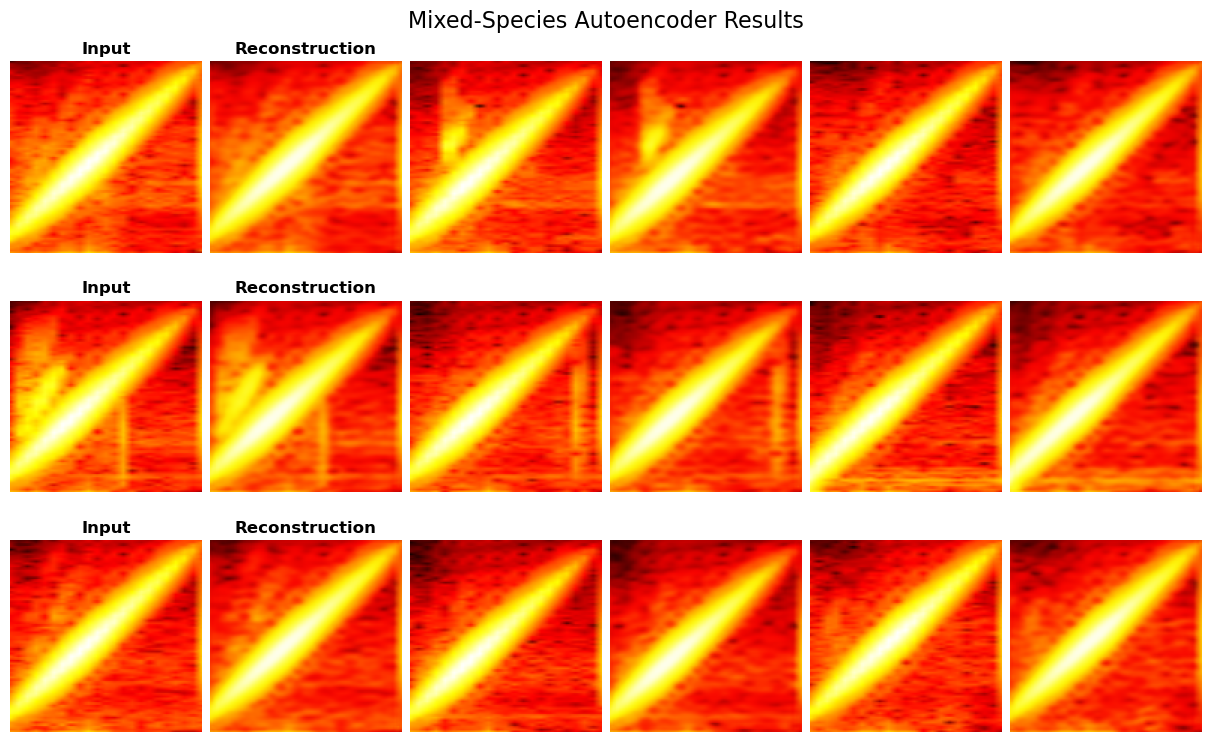

In [18]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ─── Settings ─────────────────────────────────────────────
DATA_ROOT     = "sonogram_data_forward"
MODELS_DIR    = "models"
MIXED_MODEL   = "mixed_forward_autoencoder.h5"
IMG_HEIGHT    = 128
IMG_WIDTH     = 128
IMG_CHANNELS  = 3      # change to 1 if grayscale
BATCH_SIZE    = 32
N_SAMPLES     = 50
TEST_SIZE     = 0.2
RANDOM_SEED   = 42

# ─── 1) Gather & split 50 samples per species ─────────────
species = sorted([
    d for d in os.listdir(DATA_ROOT)
    if os.path.isdir(os.path.join(DATA_ROOT, d))
])

all_paths = []
for sp in species:
    png_dir = os.path.join(DATA_ROOT, sp, "png")
    imgs = [os.path.join(png_dir, f)
            for f in os.listdir(png_dir)
            if f.lower().endswith(".png")]
    chosen = random.Random(RANDOM_SEED).sample(imgs, min(N_SAMPLES, len(imgs)))
    all_paths += chosen

train_paths, test_paths = train_test_split(
    all_paths,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True
)

# ─── 2) Build test tf.data.Dataset ───────────────────────
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img  # autoencoder: input == target

def make_ae_dataset(paths, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=RANDOM_SEED)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

test_ds = make_ae_dataset(test_paths, shuffle=False)

# ─── 3) Load the mixed‐species autoencoder ─────────────────
model_path   = os.path.join(MODELS_DIR, MIXED_MODEL)
autoencoder  = tf.keras.models.load_model(model_path)

# ─── 4) Fetch one batch and predict ───────────────────────
for x_batch, _ in test_ds.take(1):
    reconstructions = autoencoder.predict(x_batch)
    break

# ─── 5) Plot inputs vs. reconstructions ──────────────────
n    = min(9, x_batch.shape[0])
rows = (n // 3) + (1 if n % 3 else 0)
cols = 6  # each row: [input, recon] × 3

fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2.5), constrained_layout=True)
axes = axes.flatten()

for i in range(n):
    # Input
    axes[i*2].imshow(x_batch[i].numpy())
    axes[i*2].axis("off")
    if i % 3 == 0:
        axes[i*2].set_title("Input", fontweight="bold")
    # Reconstruction
    axes[i*2+1].imshow(reconstructions[i])
    axes[i*2+1].axis("off")
    if i % 3 == 0:
        axes[i*2+1].set_title("Reconstruction", fontweight="bold")

# turn off extra axes
for j in range(n*2, len(axes)):
    axes[j].axis("off")

fig.suptitle("Mixed-Species Autoencoder Results", fontsize=16)
plt.show()


1/1 [==============================] - 0s 87ms/step


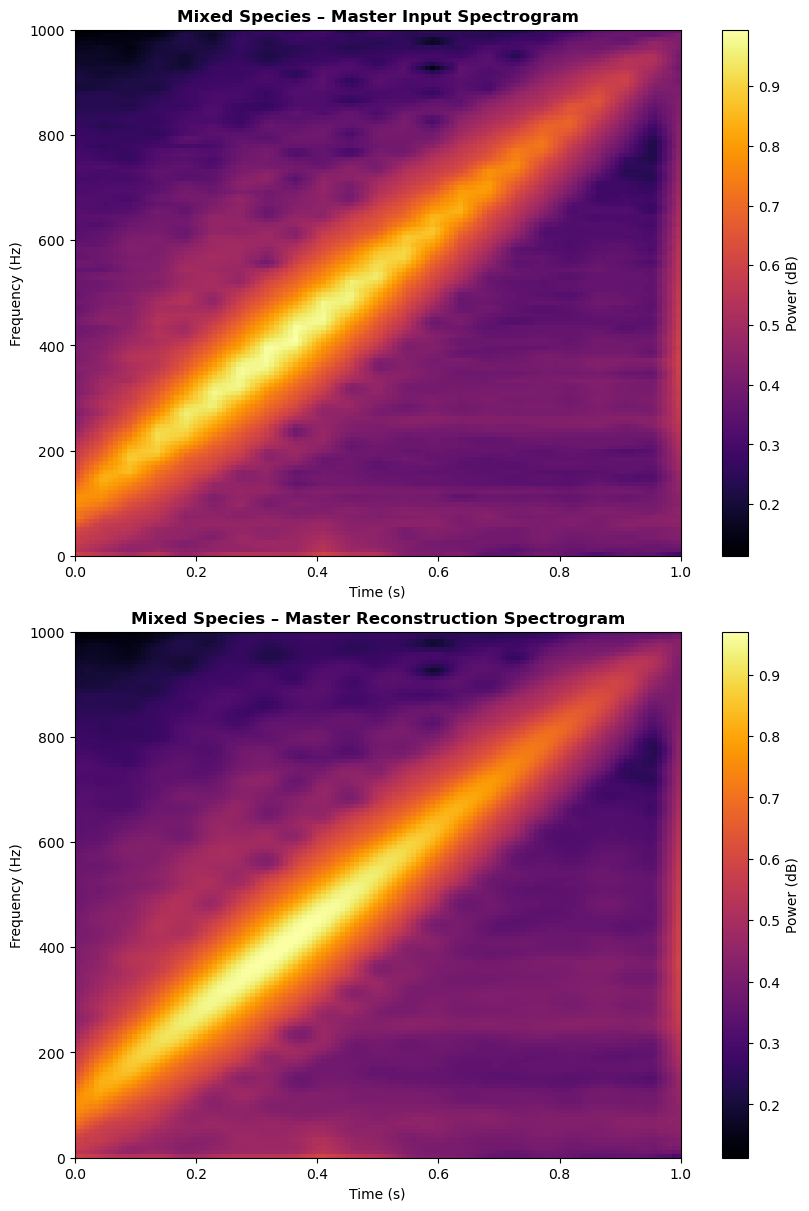

In [19]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ─── Settings ─────────────────────────────────────────────
DATA_ROOT     = "sonogram_data_forward"
MODEL_PATH    = os.path.join("models", "mixed_forward_autoencoder.h5")
IMG_HEIGHT    = 128
IMG_WIDTH     = 128
IMG_CHANNELS  = 3
BATCH_SIZE    = 32
N_SAMPLES     = 50
TEST_SIZE     = 0.2
RANDOM_SEED   = 42

# ─── 1) Gather & split 50 samples per species ─────────────
species = sorted(d for d in os.listdir(DATA_ROOT)
                 if os.path.isdir(os.path.join(DATA_ROOT, d)))

all_paths = []
for sp in species:
    png_dir = os.path.join(DATA_ROOT, sp, "png")
    imgs = [os.path.join(png_dir, f)
            for f in os.listdir(png_dir)
            if f.lower().endswith(".png")]
    chosen = random.Random(RANDOM_SEED).sample(imgs, min(N_SAMPLES, len(imgs)))
    all_paths += chosen

_, test_paths = train_test_split(
    all_paths,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True
)

# ─── 2) Build test tf.data.Dataset ───────────────────────
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img

def make_dataset(paths):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

test_ds = make_dataset(test_paths)

# ─── 3) Load mixed‐species autoencoder ───────────────────
autoencoder = tf.keras.models.load_model(MODEL_PATH)

# ─── 4) Collect all inputs & reconstructions ────────────
all_inputs = []
all_recons = []
for x_batch, _ in test_ds:
    recon = autoencoder.predict(x_batch)
    all_inputs.append(x_batch.numpy())
    all_recons.append(recon)
all_inputs = np.concatenate(all_inputs, axis=0)        # shape (N, H, W, C)
all_recons = np.concatenate(all_recons, axis=0)

# ─── 5) Compute master spectrograms ──────────────────────
# mean across examples -> (H, W, C)
mean_input = np.mean(all_inputs, axis=0)
mean_recon = np.mean(all_recons,   axis=0)

# collapse color channels -> (H, W)
master_input  = np.mean(mean_input, axis=-1)
master_recon  = np.mean(mean_recon, axis=-1)

# ─── 6) Plot averaged spectrograms ───────────────────────
extent = [0, 1, 0, 1000]  # adjust freq max if needed

fig, axes = plt.subplots(2, 1, figsize=(8, 12), constrained_layout=True)

im0 = axes[0].imshow(master_input, origin='upper', aspect='auto', extent=extent, cmap='inferno')
axes[0].set_title("Mixed Species – Master Input Spectrogram", fontweight='bold')
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (Hz)")
fig.colorbar(im0, ax=axes[0], label="Power (dB)")

im1 = axes[1].imshow(master_recon, origin='upper', aspect='auto', extent=extent, cmap='inferno')
axes[1].set_title("Mixed Species – Master Reconstruction Spectrogram", fontweight='bold')
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (Hz)")
fig.colorbar(im1, ax=axes[1], label="Power (dB)")

plt.show()


In [20]:
# … after you’ve computed master_input …

n_freq, n_time = master_input.shape
# original mapping (0 → 2000 Hz) halved:
freqs = np.linspace(extent[2], extent[3], n_freq) / 2  
times = np.linspace(extent[0], extent[1], n_time)

# find each bin’s peak power and time
peak_power    = master_input.max(axis=1)
peak_time_idx = np.argmax(master_input, axis=1)
peak_times    = times[peak_time_idx]

# sort by descending peak power
sorted_idx       = np.argsort(peak_power)[::-1]
sorted_freqs     = freqs[sorted_idx]
sorted_powers    = peak_power[sorted_idx]
sorted_peak_times = peak_times[sorted_idx]

# print top‐N
N = 100
print(f"Top {N} peaks (with frequencies halved):")
for i in range(N):
    f = sorted_freqs[i]
    p = sorted_powers[i]
    t = sorted_peak_times[i]
    print(f"{i+1:2d}. {f:7.1f} Hz → {p:.3f} dB at t={t:.3f} s")


Top 100 peaks (with frequencies halved):
 1.   295.3 Hz → 0.995 dB at t=0.362 s
 2.   303.1 Hz → 0.989 dB at t=0.323 s
 3.   287.4 Hz → 0.988 dB at t=0.362 s
 4.   291.3 Hz → 0.988 dB at t=0.362 s
 5.   315.0 Hz → 0.988 dB at t=0.315 s
 6.   311.0 Hz → 0.987 dB at t=0.315 s
 7.   283.5 Hz → 0.986 dB at t=0.362 s
 8.   307.1 Hz → 0.986 dB at t=0.315 s
 9.   326.8 Hz → 0.981 dB at t=0.276 s
10.   275.6 Hz → 0.980 dB at t=0.409 s
11.   299.2 Hz → 0.979 dB at t=0.354 s
12.   271.7 Hz → 0.979 dB at t=0.409 s
13.   322.8 Hz → 0.979 dB at t=0.276 s
14.   318.9 Hz → 0.979 dB at t=0.315 s
15.   279.5 Hz → 0.976 dB at t=0.402 s
16.   267.7 Hz → 0.975 dB at t=0.409 s
17.   330.7 Hz → 0.973 dB at t=0.268 s
18.   263.8 Hz → 0.973 dB at t=0.409 s
19.   338.6 Hz → 0.973 dB at t=0.268 s
20.   346.5 Hz → 0.972 dB at t=0.228 s
21.   259.8 Hz → 0.971 dB at t=0.409 s
22.   334.6 Hz → 0.970 dB at t=0.268 s
23.   252.0 Hz → 0.963 dB at t=0.457 s
24.   255.9 Hz → 0.963 dB at t=0.449 s
25.   350.4 Hz → 0.961 

Epoch 1/1000
3/3 - 1s - loss: 0.1773 - val_loss: 0.1088 - 1s/epoch - 491ms/step
Epoch 2/1000
3/3 - 1s - loss: 0.0849 - val_loss: 0.0650 - 888ms/epoch - 296ms/step
Epoch 3/1000
3/3 - 1s - loss: 0.0584 - val_loss: 0.0508 - 854ms/epoch - 285ms/step
Epoch 4/1000
3/3 - 1s - loss: 0.0491 - val_loss: 0.0369 - 880ms/epoch - 293ms/step
Epoch 5/1000
3/3 - 1s - loss: 0.0357 - val_loss: 0.0293 - 885ms/epoch - 295ms/step
Epoch 6/1000
3/3 - 1s - loss: 0.0249 - val_loss: 0.0219 - 1s/epoch - 336ms/step
Epoch 7/1000
3/3 - 1s - loss: 0.0209 - val_loss: 0.0210 - 1s/epoch - 340ms/step
Epoch 8/1000
3/3 - 1s - loss: 0.0216 - val_loss: 0.0213 - 995ms/epoch - 332ms/step
Epoch 9/1000
3/3 - 1s - loss: 0.0218 - val_loss: 0.0219 - 1s/epoch - 341ms/step
Epoch 10/1000


KeyboardInterrupt: 